In [313]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split

import scipy.stats as stats
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy.stats import kruskal

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer

from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

from sklearn.metrics import r2_score

In [314]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [315]:
df = pd.read_csv("smartphones_outliers_treated.csv")
df.sample(5)

,price,rating,spec_score,processor_brand,processor_core,clock_speed,has_ir,has_nfc,has_5g,ram_gb,rom_gb,brand,battery_capacity_mah,fast_charging_watt,screen_size_inch,foldable_display,display_refresh_rate,ppi,num_rear_cameras,num_front_cameras,rear_primary_mp,front_primary_mp,expandable_memory_supported,expandable_memory_limit,screen_type
3648,12999.0,4.30,66,kirin,octa,2.157143,0,0,0,6.0,128.0,Huawei,5000.0,5.0,6.52,0,90.0,269.10,3,1,50.0,5.0,1,256.0,LCD
776,30999.0,4.65,86,dimensity,octa,3.350000,0,0,1,12.0,256.0,Vivo,5500.0,80.0,6.78,0,120.0,452.87,2,1,50.0,50.0,0,0.0,AMOLED
2807,19990.0,4.75,79,dimensity,octa,2.200000,0,0,1,8.0,128.0,Others,5000.0,40.0,6.70,0,90.0,388.32,2,1,50.0,8.0,1,1024.0,LCD
783,24990.0,4.50,84,dimensity,octa,3.000000,0,1,1,8.0,128.0,OnePlus,4500.0,80.0,6.43,0,90.0,409.30,3,1,50.0,32.0,0,0.0,SUPER AMOLED
1183,89990.0,4.30,85,snapdragon,octa,2.813256,1,1,1,12.0,256.0,Xiaomi,6100.0,100.0,6.78,0,120.0,517.56,3,1,50.0,50.0,0,0.0,AMOLED


In [316]:
df.duplicated().sum()

1

In [317]:
df.drop_duplicates(inplace = True)

In [318]:
df.shape

(4057, 25)

In [319]:
df['processor_core'].unique()

array(['octa', 'quad', 'hexa', 'nine'], dtype=object)

In [320]:
df[df['processor_core'] == 'nine']

,price,rating,spec_score,processor_brand,processor_core,clock_speed,has_ir,has_nfc,has_5g,ram_gb,rom_gb,brand,battery_capacity_mah,fast_charging_watt,screen_size_inch,foldable_display,display_refresh_rate,ppi,num_rear_cameras,num_front_cameras,rear_primary_mp,front_primary_mp,expandable_memory_supported,expandable_memory_limit,screen_type
3212,47999.0,4.1,78,tensor,nine,3.0,0,1,1,8.0,256.0,Google,4575.0,30.0,6.2,0,120.0,424.48,2,1,50.0,5.0,0,0.0,OLED
3235,63999.0,4.5,77,tensor,nine,3.0,0,1,1,8.0,128.0,Google,4575.0,30.0,6.2,0,120.0,424.48,2,1,50.0,5.0,0,0.0,OLED


In [321]:
# Removing the above two rows as there are two phones only.
df.drop(index = [3212, 3235], inplace = True)

# brand

In [322]:
df['brand'].nunique()

41

In [323]:
X = df.drop(columns = 'price')
y = df['price']

In [324]:
# ANOVA to decide whether brand is an important feature or not

In [325]:
# Check normality for each brand
for brand in X['brand'].unique():
    data = y[X['brand'] == brand]
    
    # Shapiro-Wilk test for normality
    stat, p_value = stats.shapiro(data)
    print(f"Brand: {brand} - Shapiro-Wilk Test p-value: {p_value}")

Brand: Doogee - Shapiro-Wilk Test p-value: 0.0019838914665652086
Brand: Realme - Shapiro-Wilk Test p-value: 4.344136541816401e-25
Brand: OnePlus - Shapiro-Wilk Test p-value: 4.984930839879171e-13
Brand: Xiaomi - Shapiro-Wilk Test p-value: 5.602337972172654e-27
Brand: Motorola - Shapiro-Wilk Test p-value: 7.221651193266e-19
Brand: Samsung - Shapiro-Wilk Test p-value: 1.1080029303685845e-27
Brand: Meizu - Shapiro-Wilk Test p-value: 0.4242889682189965
Brand: Others - Shapiro-Wilk Test p-value: 2.0503224598861e-14
Brand: Nubia - Shapiro-Wilk Test p-value: 0.004892210450642799
Brand: Oukitel - Shapiro-Wilk Test p-value: 0.05817709330860734
Brand: Vivo - Shapiro-Wilk Test p-value: 2.5960223347209296e-28
Brand: Poco - Shapiro-Wilk Test p-value: 8.99955566660502e-10
Brand: Google - Shapiro-Wilk Test p-value: 0.0020777427570773097
Brand: Oppo - Shapiro-Wilk Test p-value: 6.0481827521094845e-24
Brand: Honor - Shapiro-Wilk Test p-value: 3.5633687151852096e-16
Brand: iKall - Shapiro-Wilk Test p-va

In [326]:
# Checking homogeneity of variances
grouped_prices = [y[X['brand'] == brand] for brand in X['brand'].unique()]
stat, p_value = levene(*grouped_prices)
print(f"Levene’s Test p-value: {p_value}")

Levene’s Test p-value: 5.286899708494924e-73


In [327]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between brand and price.
grouped_prices = [y[X['brand'] == brand] for brand in X['brand'].unique()]

stat, p_value = kruskal(*grouped_prices)
print("Kruskal-Wallis Test p-value:", p_value)

Kruskal-Wallis Test p-value: 5.486464995335601e-176


In [328]:
# We can see that there is significant relationship between price and brand.

# Processor brand

In [329]:
# check normality for each processor brand
for brand in X['processor_brand'].unique():
    data = y[X['processor_brand'] == brand]

    # Shapiro-Wilk test for normality
    stat, p_value = stats.shapiro(data)
    print(f"Brand: {brand} - Shapiro-Wilk Test p-value: {p_value}")

Brand: helio - Shapiro-Wilk Test p-value: 4.2995680593955985e-33
Brand: dimensity - Shapiro-Wilk Test p-value: 5.0003745512543555e-36
Brand: snapdragon - Shapiro-Wilk Test p-value: 4.675234926717517e-45
Brand: unisoc - Shapiro-Wilk Test p-value: 1.579022049458379e-23
Brand: exynos - Shapiro-Wilk Test p-value: 6.996478915186834e-16
Brand: mediatek - Shapiro-Wilk Test p-value: 1.7047012914180465e-13
Brand: kirin - Shapiro-Wilk Test p-value: 1.0200823089094639e-07
Brand: bionic - Shapiro-Wilk Test p-value: 0.06923875245704003
Brand: tensor - Shapiro-Wilk Test p-value: 0.03938143951170925
Brand: tiger - Shapiro-Wilk Test p-value: 0.0002861960755722195
Brand: other - Shapiro-Wilk Test p-value: 0.033165837340804284


In [330]:
# checking homogeneity of variances
grouped_prices = [y[X['processor_brand'] == brand] for brand in X['processor_brand'].unique()]
stat, p_value = levene(*grouped_prices)
print(f"Levene’s Test p-value: {p_value}")

Levene’s Test p-value: 2.313995157420618e-107


In [331]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between processor brand and price.
stat, p_value = kruskal(*grouped_prices)
print("Kruskal-Wallis Test p-value:", p_value)

Kruskal-Wallis Test p-value: 0.0


In [332]:
# We can see that there is significant relationship between price and processor_brand.

# spec score

In [333]:
df['spec_score'].unique()

array([89, 80, 74, 78, 75, 71, 69, 84, 86, 88, 63, 67, 93, 72, 82, 70, 61,
       66, 65, 87, 52, 59, 90, 91, 77, 83, 85, 76, 57, 81, 95, 94, 79, 73,
       64, 68, 92, 62, 55, 96, 56, 53, 49, 60, 58, 54, 97, 51, 50, 99, 48,
       98], dtype=int64)

In [334]:
# Make the spec_score column a categorical one by quantile binning
X['spec_score_cat'] = pd.qcut(df['spec_score'], q = 3, labels = ['Low', 'Mid', 'High'])

In [335]:
X['spec_score'].quantile(0.33)

74.0

In [336]:
X['spec_score'].quantile(0.66)

83.0

In [337]:
X['spec_score'].max()

99

In [338]:
# Applying one way ANOVA test to check the relationship between spec_score_cat and price

In [339]:
# Checking normality for each spec score category
for score in X['spec_score_cat'].unique():
    data = y[X['spec_score_cat'] == score]

    stat, p_value = stats.shapiro(data)
    print(f"score: {score} - Shapiro-Wilk Test p-value: {p_value}")

score: High - Shapiro-Wilk Test p-value: 4.816288362236982e-36
score: Mid - Shapiro-Wilk Test p-value: 2.053026571581163e-45
score: Low - Shapiro-Wilk Test p-value: 1.7447651587122728e-43


In [340]:
# levene test for homogeneity
grouped_prices = [y[X['spec_score_cat'] == score] for score in X['spec_score_cat'].unique()]
stat, p_value = levene(*grouped_prices)
print(f"Levene’s Test p-value: {p_value}")

Levene’s Test p-value: 1.976019558690751e-192


In [341]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between processor spec_Score_cat and price.
stat, p_value = kruskal(*grouped_prices)
print("Kruskal-Wallis Test p-value:", p_value)

Kruskal-Wallis Test p-value: 0.0


In [342]:
# We can see that there is significant relationship between price and spec_score_cat.

# processor core

In [343]:
df['processor_core'].value_counts()

processor_core
octa    3830
quad     166
hexa      59
Name: count, dtype: int64

In [344]:
# Checking normality for each processor_core category
for core in X['processor_core'].unique():
    data = y[X['processor_core'] == core]

    stat, p_value = stats.shapiro(data)
    print(f"score: {core} - Shapiro-Wilk Test p-value: {p_value}")

score: octa - Shapiro-Wilk Test p-value: 1.0294413067842448e-65
score: quad - Shapiro-Wilk Test p-value: 5.076954888858291e-16
score: hexa - Shapiro-Wilk Test p-value: 0.08117536183968181


In [345]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between processor core and price.
grouped_prices = [y[X['processor_core'] == core] for core in X['processor_core'].unique()]
stat, p_value = kruskal(*grouped_prices)
print("Kruskal-Wallis Test p-value:", p_value)

Kruskal-Wallis Test p-value: 5.6127988184051275e-84


In [346]:
# We can see that there is significant relationship between price and processor_core.

# ram_gb

In [347]:
df['ram_gb'].value_counts()

ram_gb
8.0     1349
4.0      936
6.0      767
12.0     547
3.0      225
2.0      152
16.0      79
Name: count, dtype: int64

In [348]:
df.shape

(4055, 25)

In [349]:
# Checking normality for each RAM category
for ram in X['ram_gb'].unique():
    data = y[X['ram_gb'] == ram]

    stat, p_value = stats.shapiro(data)
    print(f"score: {ram} - Shapiro-Wilk Test p-value: {p_value}")

score: 8.0 - Shapiro-Wilk Test p-value: 1.6961248339495414e-46
score: 6.0 - Shapiro-Wilk Test p-value: 5.616778718197171e-42
score: 4.0 - Shapiro-Wilk Test p-value: 1.016953249963676e-40
score: 12.0 - Shapiro-Wilk Test p-value: 2.5429863685027843e-22
score: 16.0 - Shapiro-Wilk Test p-value: 0.00011207053478978585
score: 2.0 - Shapiro-Wilk Test p-value: 9.26237907281843e-11
score: 3.0 - Shapiro-Wilk Test p-value: 3.573921193281789e-16


In [350]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between RAM and price.
grouped_prices = [y[X['ram_gb'] == ram] for ram in X['ram_gb'].unique()]
stat, p_value = kruskal(*grouped_prices)
print("Kruskal-Wallis Test p-value:", p_value)

Kruskal-Wallis Test p-value: 0.0


In [351]:
# So, RAM size is an important feature for predicting price.

# rom_gb

In [352]:
df['rom_gb'].value_counts()

rom_gb
128.0     1802
256.0     1011
64.0       713
32.0       291
512.0      159
16.0        60
1024.0      19
Name: count, dtype: int64

In [353]:
# Checking normality for each ROM category
for rom in X['rom_gb'].unique():
    data = y[X['rom_gb'] == rom]

    stat, p_value = stats.shapiro(data)
    print(f"score: {rom} - Shapiro-Wilk Test p-value: {p_value}")

score: 512.0 - Shapiro-Wilk Test p-value: 2.6114560168853866e-06
score: 128.0 - Shapiro-Wilk Test p-value: 1.5917329385249466e-51
score: 64.0 - Shapiro-Wilk Test p-value: 9.696820495600116e-32
score: 256.0 - Shapiro-Wilk Test p-value: 2.3500873329991794e-34
score: 32.0 - Shapiro-Wilk Test p-value: 6.383582338257943e-20
score: 16.0 - Shapiro-Wilk Test p-value: 1.1622924613395449e-08
score: 1024.0 - Shapiro-Wilk Test p-value: 0.015865908404140018


In [354]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between ROM and price.
grouped_prices = [y[X['rom_gb'] == rom] for rom in X['rom_gb'].unique()]
stat, p_value = kruskal(*grouped_prices)
print("Kruskal-Wallis Test p-value:", p_value)

Kruskal-Wallis Test p-value: 0.0


In [355]:
# ROM size is an important feature for predicting price.

# display_refresh_rate

In [356]:
df['display_refresh_rate'].value_counts()

display_refresh_rate
120.0    2064
90.0     1728
144.0     211
165.0      40
240.0       8
185.0       4
Name: count, dtype: int64

In [357]:
# Filter out very rare categories (e.g., < 10 samples)
valid_rates = X['display_refresh_rate'].value_counts()[X['display_refresh_rate'].value_counts() >= 10].index
filtered_X = X[X['display_refresh_rate'].isin(valid_rates)]
filtered_y = y[X['display_refresh_rate'].isin(valid_rates)]

In [358]:
# Checking normality for each refresh rate category
for rate in filtered_X['display_refresh_rate'].unique():
    data = filtered_y[filtered_X['display_refresh_rate'] == rate]

    stat, p_value = stats.shapiro(data)
    print(f"score: {rate} - Shapiro-Wilk Test p-value: {p_value}")

score: 120.0 - Shapiro-Wilk Test p-value: 1.124173568326738e-51
score: 90.0 - Shapiro-Wilk Test p-value: 8.93240155116087e-45
score: 165.0 - Shapiro-Wilk Test p-value: 0.00030975260670827086
score: 144.0 - Shapiro-Wilk Test p-value: 1.6706133143230953e-16


In [359]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between display refresh rate and price.
grouped_prices = [filtered_y[filtered_X['display_refresh_rate'] == rate] for rate in valid_rates]

# Apply Kruskal-Wallis test
stat, p_value = kruskal(*grouped_prices)
print(f"Kruskal-Wallis Test p-value: {p_value}")

Kruskal-Wallis Test p-value: 0.0


In [360]:
# So, display_refresh_rate is an important feature for predicting price.

# num_rear_cameras

In [361]:
df['num_rear_cameras'].value_counts()

num_rear_cameras
3    1763
2    1452
4     464
1     376
Name: count, dtype: int64

In [362]:
# Checking normality for each no. of rear cameras
for num in X['num_rear_cameras'].unique():
    data = y[X['num_rear_cameras'] == num]

    stat, p_value = stats.shapiro(data)
    print(f"score: {num} - Shapiro-Wilk Test p-value: {p_value}")

score: 3 - Shapiro-Wilk Test p-value: 5.950388672720791e-48
score: 2 - Shapiro-Wilk Test p-value: 8.921068992496837e-47
score: 4 - Shapiro-Wilk Test p-value: 6.44134157844826e-31
score: 1 - Shapiro-Wilk Test p-value: 4.40862546398369e-30


In [363]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between num_rear_cameras and price.
grouped_prices = [y[X['num_rear_cameras'] == num] for num in X['num_rear_cameras'].unique()]
stat, p_value = kruskal(*grouped_prices)
print("Kruskal-Wallis Test p-value:", p_value)

Kruskal-Wallis Test p-value: 2.405340681470067e-152


In [364]:
# So, num_rear_cameras is an important feature for predicting price.

# num_front_cameras

In [365]:
# Checking normality for each no. of front cameras
for num in X['num_front_cameras'].unique():
    data = y[X['num_front_cameras'] == num]

    stat, p_value = stats.shapiro(data)
    print(f"score: {num} - Shapiro-Wilk Test p-value: {p_value}")

score: 1 - Shapiro-Wilk Test p-value: 1.7393048990710194e-65
score: 2 - Shapiro-Wilk Test p-value: 2.2186523824143093e-09
score: 0 - Shapiro-Wilk Test p-value: 0.0029648657583466833


In [366]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between num_front_cameras and price.
grouped_prices = [y[X['num_front_cameras'] == num] for num in X['num_front_cameras'].unique()]
stat, p_value = kruskal(*grouped_prices)
print("Kruskal-Wallis Test p-value:", p_value)

Kruskal-Wallis Test p-value: 1.0860063030078394e-24


In [367]:
# So, num_front_cameras is an important feature for predicting price.

# expandable_memory_limit

In [368]:
df['expandable_memory_limit'].value_counts()

expandable_memory_limit
0.0       1359
1024.0    1271
256.0      659
512.0      410
2048.0     166
128.0      126
64.0        24
32.0        16
1536.0      11
400.0        7
1000.0       6
Name: count, dtype: int64

In [369]:
# Filter out very rare categories (e.g., < 10 samples)
valid_limits = X['expandable_memory_limit'].value_counts()[X['expandable_memory_limit'].value_counts() >= 10].index
filtered_X = X[X['expandable_memory_limit'].isin(valid_limits)]
filtered_y = y[X['expandable_memory_limit'].isin(valid_limits)]

In [370]:
# Checking normality for each filtered expandable_memory_limit category
for limit in filtered_X['expandable_memory_limit'].unique():
    data = filtered_y[filtered_X['expandable_memory_limit'] == limit]

    stat, p_value = stats.shapiro(data)
    print(f"score: {limit} - Shapiro-Wilk Test p-value: {p_value}")

score: 512.0 - Shapiro-Wilk Test p-value: 9.482147196382525e-29
score: 1024.0 - Shapiro-Wilk Test p-value: 5.278868644184459e-49
score: 0.0 - Shapiro-Wilk Test p-value: 1.6914597991374549e-38
score: 256.0 - Shapiro-Wilk Test p-value: 2.061741044465012e-39
score: 2048.0 - Shapiro-Wilk Test p-value: 4.864666160989015e-16
score: 64.0 - Shapiro-Wilk Test p-value: 9.090263167804248e-06
score: 128.0 - Shapiro-Wilk Test p-value: 5.1715665399667016e-14
score: 1536.0 - Shapiro-Wilk Test p-value: 0.9951473935762086
score: 32.0 - Shapiro-Wilk Test p-value: 0.0009934542266006585


In [371]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between expandable_memory_limit and price.
grouped_prices = [filtered_y[filtered_X['expandable_memory_limit'] == limit] for limit in valid_limits]

# Apply Kruskal-Wallis test
stat, p_value = kruskal(*grouped_prices)
print(f"Kruskal-Wallis Test p-value: {p_value}")

Kruskal-Wallis Test p-value: 0.0


# screen_type

In [372]:
X['screen_type'].value_counts()

screen_type
LCD             2148
AMOLED          1104
SUPER AMOLED     442
OLED             353
OTHER              8
Name: count, dtype: int64

In [373]:
# Filter out very rare categories (e.g., < 10 samples)
valid_types = X['screen_type'].value_counts()[X['screen_type'].value_counts() >= 10].index
filtered_X = X[X['screen_type'].isin(valid_types)]
filtered_y = y[X['screen_type'].isin(valid_types)]

In [374]:
# Checking normality for each filtered screen type
for display_type in filtered_X['screen_type'].unique():
    data = filtered_y[filtered_X['screen_type'] == display_type]

    stat, p_value = stats.shapiro(data)
    print(f"score: {limit} - Shapiro-Wilk Test p-value: {p_value}")

score: 32.0 - Shapiro-Wilk Test p-value: 6.111591589730596e-48
score: 32.0 - Shapiro-Wilk Test p-value: 4.56748134012859e-37
score: 32.0 - Shapiro-Wilk Test p-value: 8.873395135904911e-29
score: 32.0 - Shapiro-Wilk Test p-value: 1.6632663446532048e-16


In [375]:
# We can see above that assumptions of ANOVA is violated. So, let's apply kruskal test to check relationship between screen_type and price.
grouped_prices = [filtered_y[filtered_X['screen_type'] == display_type] for display_type in valid_types]

# Apply Kruskal-Wallis test
stat, p_value = kruskal(*grouped_prices)
print(f"Kruskal-Wallis Test p-value: {p_value}")

Kruskal-Wallis Test p-value: 0.0


In [376]:
# So, screen_type is an important feature for predicting price.

In [377]:
df.columns

Index(['price', 'rating', 'spec_score', 'processor_brand', 'processor_core',
       'clock_speed', 'has_ir', 'has_nfc', 'has_5g', 'ram_gb', 'rom_gb',
       'brand', 'battery_capacity_mah', 'fast_charging_watt',
       'screen_size_inch', 'foldable_display', 'display_refresh_rate', 'ppi',
       'num_rear_cameras', 'num_front_cameras', 'rear_primary_mp',
       'front_primary_mp', 'expandable_memory_supported',
       'expandable_memory_limit', 'screen_type'],
      dtype='object')

In [378]:
df.shape

(4055, 25)

In [379]:
X.drop(columns = 'spec_score', inplace = True)

In [380]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [381]:
# Using TargetEncoder for all categorical variables because:
# 1) All categorical features showed significant correlation with price (via ANOVA),
# 2) Target encoding captures target-related patterns and works well with tree-based models,
# 3) Also data leakage is being avoided because TargetEncoder is applied only on training data (fit_transform) and then on test data (transform), 
# ensuring no data leakage. This approach is valid for train-test split scenarios.

In [382]:
cols =  ['processor_brand', 'processor_core', 'brand', 'screen_type', 'spec_score_cat']

In [383]:
t_encoder = TargetEncoder(cols = cols)

In [384]:
X_train_target_encoded = X_train.copy()
X_test_target_encoded = X_test.copy()

In [385]:
X_train_target_encoded[cols] = t_encoder.fit_transform(X_train_target_encoded[cols], y_train)
X_test_target_encoded[cols] = t_encoder.transform(X_test_target_encoded[cols])

In [386]:
X_train_target_encoded.shape

(3244, 24)

In [387]:
X_test_target_encoded.shape

(811, 24)

In [388]:
X_train_target_encoded.head()

,rating,processor_brand,processor_core,clock_speed,has_ir,has_nfc,has_5g,ram_gb,rom_gb,brand,battery_capacity_mah,fast_charging_watt,screen_size_inch,foldable_display,display_refresh_rate,ppi,num_rear_cameras,num_front_cameras,rear_primary_mp,front_primary_mp,expandable_memory_supported,expandable_memory_limit,screen_type,spec_score_cat
3602,4.35,10518.958105,26051.186396,1.80,0,1,0,4.0,128.0,18568.867978,5000.0,45.0,6.75,0,90.0,259.93,2,1,50.0,8.0,1,1024.0,13902.855038,12286.560386
436,4.25,24919.308399,26051.186396,3.35,1,1,1,12.0,512.0,25072.500000,5800.0,80.0,6.83,0,120.0,450.28,3,1,50.0,50.0,0,0.0,36549.899441,48714.216867
3485,4.25,24919.308399,26051.186396,2.60,0,0,1,8.0,256.0,11248.476598,5000.0,33.0,6.67,0,120.0,394.57,3,1,64.0,32.0,0,0.0,36549.899441,48714.216867
3651,4.25,10518.958105,26051.186396,1.80,0,0,0,4.0,64.0,18568.867978,5000.0,10.0,6.74,0,90.0,260.32,1,1,8.0,5.0,1,1024.0,13902.855038,12286.560386
3975,4.55,33374.110420,26051.186396,3.20,1,1,1,8.0,256.0,36294.113163,5500.0,100.0,6.78,0,120.0,450.42,3,1,50.0,16.0,0,0.0,36549.899441,48714.216867


# RFE with Random Forest

In [389]:
estimator = RandomForestRegressor()

selector = RFE(estimator, n_features_to_select = X_train_target_encoded.shape[1], step = 1)
selector = selector.fit(X_train_target_encoded, y_train)


selected_coefficients = selector.estimator_.feature_importances_

# Organize the results into a DataFrame
fi_df1 = pd.DataFrame({
    'feature': X_train_target_encoded.columns,
    'rf_importance': selected_coefficients
}).sort_values(by='rf_importance', ascending = False)

fi_df1

,feature,rf_importance
3,clock_speed,0.442319
12,screen_size_inch,0.122684
19,front_primary_mp,0.098416
15,ppi,0.059756
9,brand,0.046539
7,ram_gb,0.044355
8,rom_gb,0.024001
22,screen_type,0.020482
10,battery_capacity_mah,0.019482
16,num_rear_cameras,0.018348


# RFE with Xgboost

In [390]:
estimator = XGBRegressor()
selector = RFE(estimator, n_features_to_select = X_train_target_encoded.shape[1], step = 1)
selector = selector.fit(X_train_target_encoded, y_train)

selected_coefficients = selector.estimator_.feature_importances_

fi_df2 = pd.DataFrame({
    'feature' : X_train_target_encoded.columns,
    'xgb_importance' : selected_coefficients
}).sort_values(by = 'xgb_importance', ascending = False)

fi_df2

,feature,xgb_importance
3,clock_speed,0.204976
19,front_primary_mp,0.155875
13,foldable_display,0.119178
7,ram_gb,0.073553
12,screen_size_inch,0.066365
8,rom_gb,0.057210
23,spec_score_cat,0.038379
16,num_rear_cameras,0.037938
22,screen_type,0.035293
5,has_nfc,0.026768


# RFE with Gradient Boost

In [391]:
estimator = GradientBoostingRegressor()
selector = RFE(estimator, n_features_to_select = X_train_target_encoded.shape[1], step = 1)
selector = selector.fit(X_train_target_encoded, y_train)

selected_coefficients = selector.estimator_.feature_importances_

fi_df3 = pd.DataFrame({
    'feature' : X_train_target_encoded.columns,
    'gb_importance' : selected_coefficients
}).sort_values(by = 'gb_importance', ascending = False)

fi_df3

,feature,gb_importance
3,clock_speed,0.406312
12,screen_size_inch,0.109868
19,front_primary_mp,0.078197
15,ppi,0.071966
7,ram_gb,0.062655
9,brand,0.059375
23,spec_score_cat,0.047580
13,foldable_display,0.039323
8,rom_gb,0.036449
16,num_rear_cameras,0.017811


In [392]:
# Before moving on to linear models, transforming our target column to reduce skewness.

<Axes: xlabel='price', ylabel='Density'>

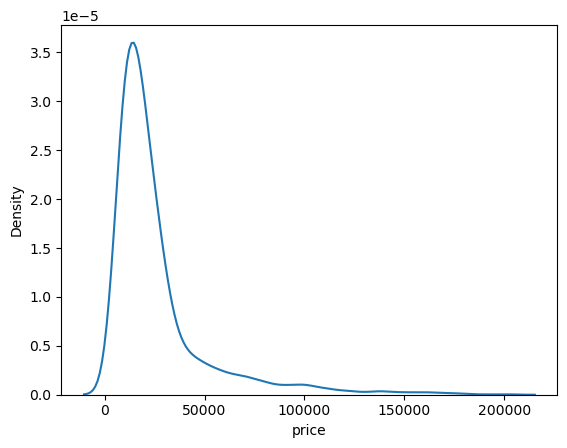

In [393]:
sns.kdeplot(y_train)

<Axes: xlabel='price', ylabel='Density'>

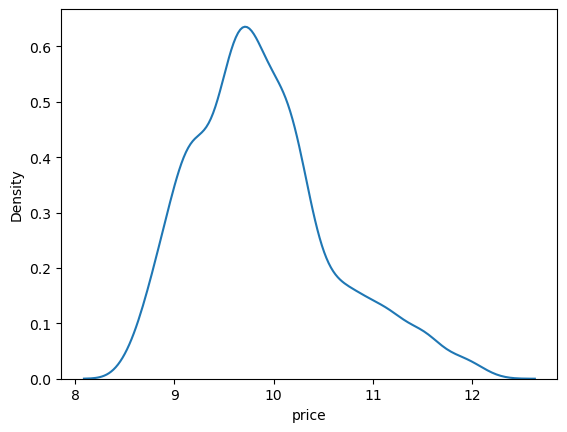

In [394]:
sns.kdeplot(np.log1p(y_train))

In [395]:
pt = PowerTransformer()
y_train_trf = pt.fit_transform(y_train.to_frame())
y_test_trf = pt.transform(y_test.to_frame())

In [396]:
y_train_trf = pd.Series(y_train_trf.reshape(3244,))
y_test_trf = pd.Series(y_test_trf.reshape(811,))

In [397]:
y_train_trf.skew()

0.03984303776593457

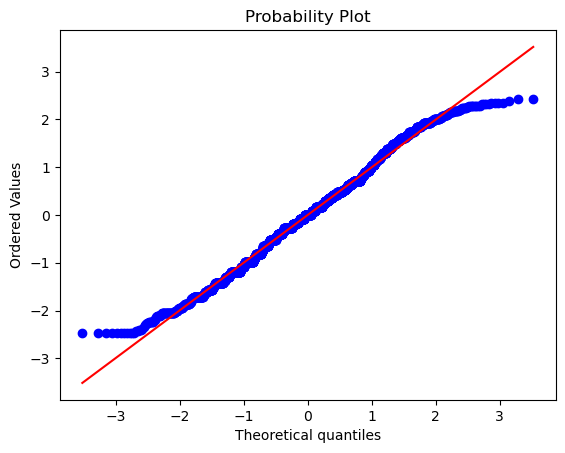

In [398]:
stats.probplot(y_train_trf, dist = "norm", plot=plt)
plt.show()

# RFE with LASSO Regression

In [399]:
# scaling the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_target_encoded)
X_scaled = pd.DataFrame(X_scaled, columns = X_train_target_encoded.columns, index = X_train_target_encoded.index)

In [400]:
estimator = Lasso(alpha = 0.01)
selector = RFE(estimator, n_features_to_select = X_train_target_encoded.shape[1], step = 1)
selector = selector.fit(X_scaled, y_train_trf)

selected_coefficients = selector.estimator_.coef_

fi_df4 = pd.DataFrame({
    'feature' : X_train_target_encoded.columns,
    'lasso_importance' : selected_coefficients
}).sort_values(by = 'lasso_importance', ascending = False)

fi_df4

,feature,lasso_importance
7,ram_gb,0.206621
9,brand,0.175441
14,display_refresh_rate,0.146809
15,ppi,0.144808
3,clock_speed,0.124159
13,foldable_display,0.118367
6,has_5g,0.102126
5,has_nfc,0.097950
16,num_rear_cameras,0.095919
19,front_primary_mp,0.055347


# Permutation Importance

In [401]:
rf = RandomForestRegressor()
rf.fit(X_train_target_encoded, y_train)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf, X_test_target_encoded, y_test, n_repeats=30, random_state=42)

fi_df5 = pd.DataFrame({
    'feature': X_train_target_encoded.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df5

,feature,permutation_importance
3,clock_speed,0.462141
12,screen_size_inch,0.124762
19,front_primary_mp,0.098145
7,ram_gb,0.056345
15,ppi,0.033231
23,spec_score_cat,0.032453
9,brand,0.030901
13,foldable_display,0.030583
14,display_refresh_rate,0.019943
10,battery_capacity_mah,0.016445


In [402]:
final_fi_df = fi_df1.merge(fi_df2,on='feature').merge(fi_df3,on='feature').merge(fi_df4,on='feature').merge(fi_df5,on='feature').set_index('feature')

In [403]:
final_fi_df

,rf_importance,xgb_importance,gb_importance,lasso_importance,permutation_importance
feature,,,,,
clock_speed,0.442319,0.204976,0.406312,0.124159,0.462141
screen_size_inch,0.122684,0.066365,0.109868,-0.001886,0.124762
front_primary_mp,0.098416,0.155875,0.078197,0.055347,0.098145
ppi,0.059756,0.022848,0.071966,0.144808,0.033231
brand,0.046539,0.024522,0.059375,0.175441,0.030901
ram_gb,0.044355,0.073553,0.062655,0.206621,0.056345
rom_gb,0.024001,0.057210,0.036449,0.047446,0.009419
screen_type,0.020482,0.035293,0.013311,0.043754,0.014402
battery_capacity_mah,0.019482,0.008775,0.004187,0.007294,0.016445


In [404]:
# normalize the score
final_fi_df = final_fi_df.divide(final_fi_df.sum(axis = 0), axis = 1)

In [405]:
final_fi_df

,rf_importance,xgb_importance,gb_importance,lasso_importance,permutation_importance
feature,,,,,
clock_speed,0.442319,0.204976,0.406312,0.093064,0.471495
screen_size_inch,0.122684,0.066365,0.109868,-0.001414,0.127287
front_primary_mp,0.098416,0.155875,0.078197,0.041486,0.100132
ppi,0.059756,0.022848,0.071966,0.108542,0.033904
brand,0.046539,0.024522,0.059375,0.131503,0.031527
ram_gb,0.044355,0.073553,0.062655,0.154874,0.057486
rom_gb,0.024001,0.057210,0.036449,0.035563,0.009610
screen_type,0.020482,0.035293,0.013311,0.032796,0.014694
battery_capacity_mah,0.019482,0.008775,0.004187,0.005468,0.016778


In [406]:
final_fi_df.mean(axis=1).sort_values(ascending=False)

feature
clock_speed                    0.323633
front_primary_mp               0.094821
screen_size_inch               0.084958
ram_gb                         0.078585
ppi                            0.059403
brand                          0.058693
foldable_display               0.057850
display_refresh_rate           0.037177
rom_gb                         0.032567
num_rear_cameras               0.032270
spec_score_cat                 0.028188
has_nfc                        0.023398
screen_type                    0.023315
has_5g                         0.021003
battery_capacity_mah           0.010938
processor_brand                0.009808
rear_primary_mp                0.008201
fast_charging_watt             0.007332
num_front_cameras              0.003345
rating                         0.003038
expandable_memory_supported    0.002026
processor_core                 0.000435
has_ir                         0.000390
expandable_memory_limit       -0.001374
dtype: float64

In [408]:
# clock_speed and front_primary_mp have the highest importance, indicating they significantly affect the target variable.
# expandable_memory_limit shows negative importance, suggesting it may reduce the model's predictive power.
# Features like processor core and has_ir have very low importance and might be considered for removal.
# Now in the next notebook, we will do model selection and hyperparameter tuning firstly with all the features and then with only those features which have considerable feature importances.
# If by removing features with less importances improve the performance of our model, then we will drop those features.